## 파일정보
    
    1. Lv2: Binary Segmentation
    2. Object: Buildings
    3. Backbone: Efficientb3, Model: Unet
    4. Preprocessing:  Augmentation (HorizontalFlip, ShiftScaleRotate,RandomContrast,RandomGamma,RandomBrightness)
    5. Active learning: X

## 파라미터
    1. Batch Size : 1
    2. Learning Rate : 0.0001
    3. Epoch : 30
    4. Beta1 : 0.99, Beta2 : 0.999

## 구글 드라이브와 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 필요 라이브러리 불러오기

In [ ]:
!pip install segmentation_models

     |████████████████████████████████| 51kB 5.3MB/s 


In [ ]:
import math
import os
import glob
import json
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import re
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import tensorflow as tf

from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt

## 데이터 불러오기

In [ ]:
train_input_DIR =  '/content/drive/MyDrive/SIA/buildings/train/raw_image/' #input 경로

train_label_DIR = '/content/drive/MyDrive/SIA/buildings/train/new_label/' #label 경로 

val_input_DIR =  '/content/drive/MyDrive/SIA/buildings/val/raw_image/' #input 경로

val_label_DIR = '/content/drive/MyDrive/SIA/buildings/val/new_label/' #label 경로 

In [ ]:
train_input = glob.glob(train_input_DIR  + '*.png')
train_label  = glob.glob(train_label_DIR + '*.png')

val_input = glob.glob(val_input_DIR  + '*.png')
val_label  = glob.glob(val_label_DIR + '*.png')


train_input.sort()
train_label.sort()
val_input.sort()
val_label.sort()


In [ ]:
CLASSES = ['buildings']

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset_bi:
    CLASSES =  ['roads','buildings']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = [i.split('/')[-1] for i in images_dir]
        self.images_fps = images_dir
        self.masks_fps = masks_dir
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = mask.reshape(1024,1024,-1)

        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            # 둘다 1일 경우..
            background = 255 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
            mask = np.where(mask == 255, mask, 0)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
#         image = image/255         
        mask = mask/255
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [ ]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
       
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [ ]:
from albumentations import (
                            Compose,
                            HorizontalFlip,
                            ShiftScaleRotate,
                            OneOf,
                            RandomContrast,
                            RandomGamma,
                            RandomBrightness
   
                            )


def augmentations(prob=0.5):
    
    transformer = Compose([
                      
            HorizontalFlip(p=prob),
            ShiftScaleRotate(p=prob, shift_limit=0.1, scale_limit=.1, rotate_limit=10),
            OneOf([RandomContrast(limit=0.1, p=prob),
                   RandomGamma(gamma_limit=(90, 110), p=prob),
                   RandomBrightness(limit=0.1, p=prob)],p=prob),
            
    ], p=prob)
    return transformer

In [ ]:
CLASSES =  ['buildings']

In [ ]:
train_dataset = Dataset_bi(
    train_input,train_label,
    augmentation= augmentations(),
    classes=CLASSES,
#         preprocessing=get_preprocessing(preprocess_input),
)

In [ ]:
valid_dataset = Dataset_bi(
    val_input, val_label,
    classes=CLASSES,    
    augmentation=augmentations(),
#     augmentation=get_validation_augmentation(),
#         preprocessing=get_preprocessing(preprocess_input)

)


## 모델 설계

In [ ]:
%env SM_FRAMEWORK=tf.keras

import segmentation_models as sm

In [ ]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 1
LR = 0.0001
EPOCHS = 30
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44113920/44107200 [==============================] - 0s 0us/step


In [ ]:
# define optomizer
optim = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.99, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [ ]:
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

In [ ]:
# assert train_dataloader[0][0].shape == (BATCH_SIZE, 1024, 1024, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, 1024, 1024, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/SIA/colab_code/lhk/B_aug_01.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f299c9db3d0>>

In [ ]:
earlystopper = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/SIA/colab_code/lhk/B_aug_01.h5', verbose=1, save_best_only=True)

# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=30, 
    callbacks=[earlystopper, checkpointer,callbacks],      validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader) ,verbose = 1 
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1238/1238 [==============================] - 1255s 985ms/step - loss: 0.6423 - iou_score: 0.4215 - f1-score: 0.5537 - val_loss: 0.3932 - val_iou_score: 0.6177 - val_f1-score: 0.7446

Epoch 00001: val_loss improved from inf to 0.39325, saving model to /content/drive/MyDrive/SIA/colab_code/lhk/B_aug_01.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
1238/1238 [==============================] - 634s 512ms/step - loss: 0.4318 - iou_score: 0.5728 - f1-score: 0.7003 - val_loss: 0.4030 - val_iou_score: 0.5659 - val_f1-score: 0.7032

Epoch 00002: val_loss did not improve from 0.39325
Epoch 3/30
1238/1238 [==============================] - 634s 512ms/step - loss: 0.3519 - iou_score: 0.6219 - f1-score: 0.7454 - val_loss: 0.3208 - val_iou_score: 0.6661 - val_f1-score: 0.7846

Epoch 00003: val_loss improved from 0.39325 to 0.32083, saving model to /content/drive/MyDrive/SIA/colab_code/lhk/B_aug_01.h5
Epoch 4/30
1238/1238 [==============================] - 633s 511ms/step - loss: 0.3103 - iou_score: 0.6524 - f1-score: 0.7720 - val_loss: 0.3097 - val_iou_score: 0.6712 - val_f1-score: 0.7875

Epoch 00004: val_loss improved from 0.32083 to 0.30972, saving model to /content/drive/MyDrive/SIA/colab_code/lhk/B_aug_01.h5
Epoch 5/30
1238/1238 [==============================] - 634s 512ms/step - loss: 0.2831 - iou_score: 0.6753 - f1-score:

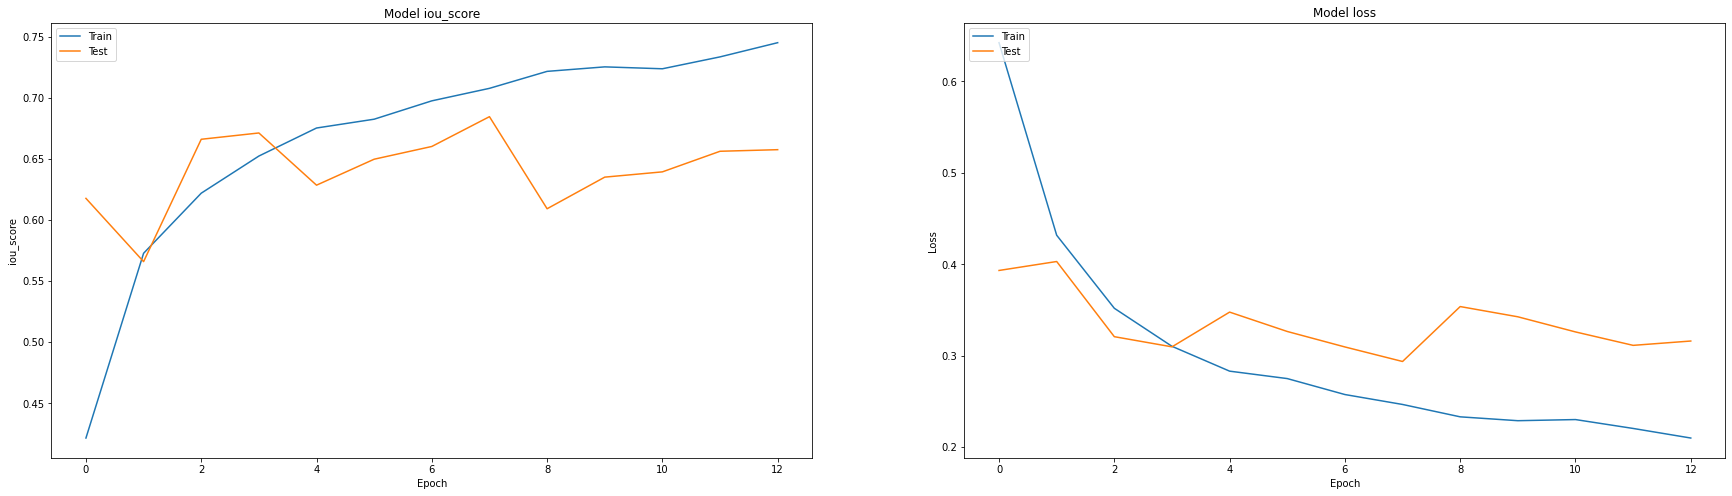

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 8))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 모델 평가

In [ ]:
test_dataset = Dataset_bi(
    val_input, val_label,
    classes=CLASSES,    
    augmentation=augmentations(),
#         preprocessing=get_preprocessing(preprocess_input)

)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# load best weights
model.load_weights('/content/drive/MyDrive/SIA/colab_code/lhk/B_aug_01.h5')


In [ ]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss: 0.29131
mean iou_score: 0.68479
mean f1-score: 0.79248


## 원본 이미지와 학습 결과 비교

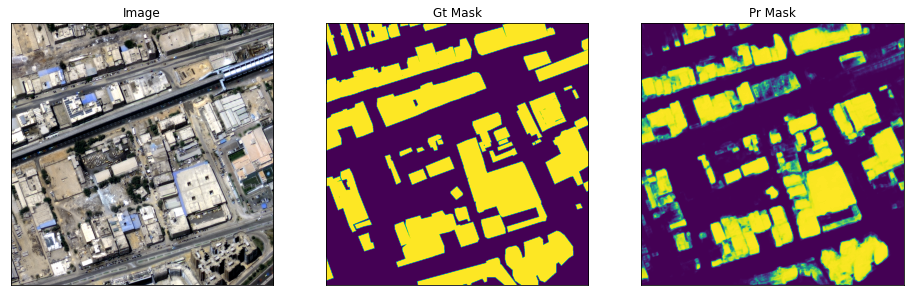

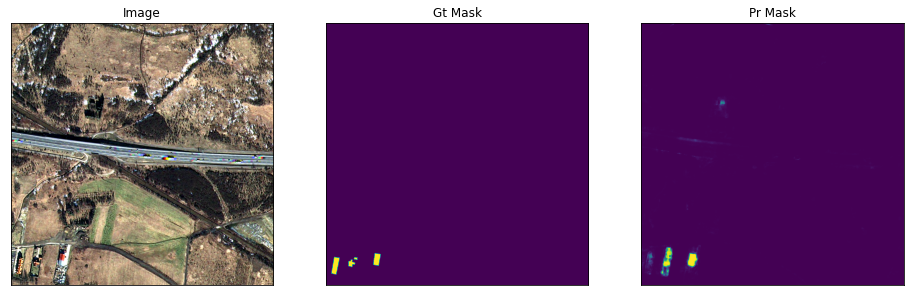

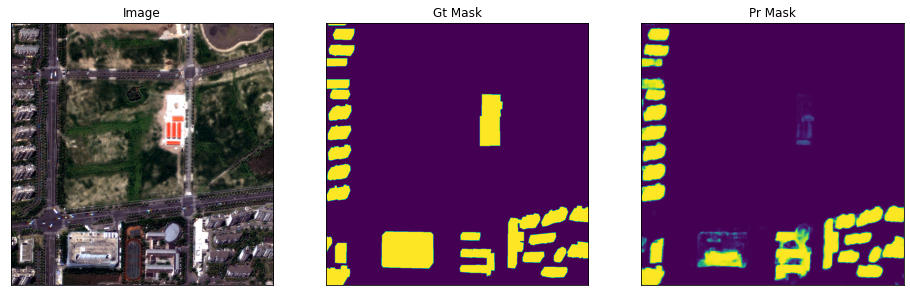

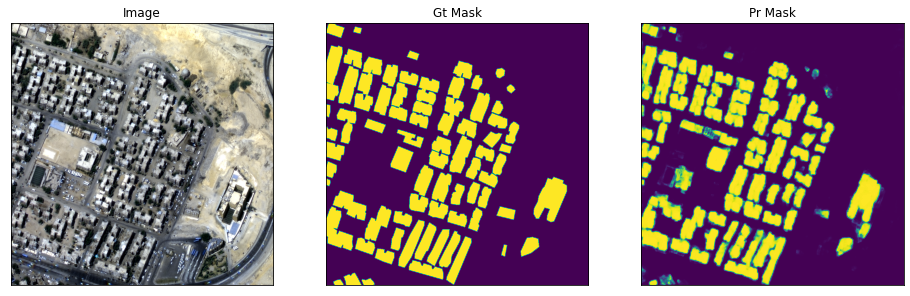

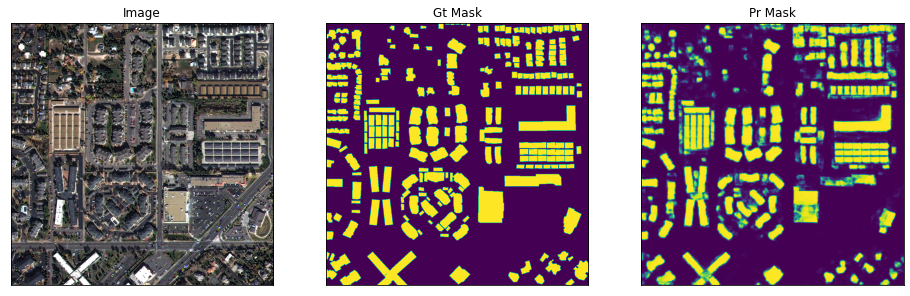

In [ ]:
## 원본 이미지와 학습 결과 비교n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )

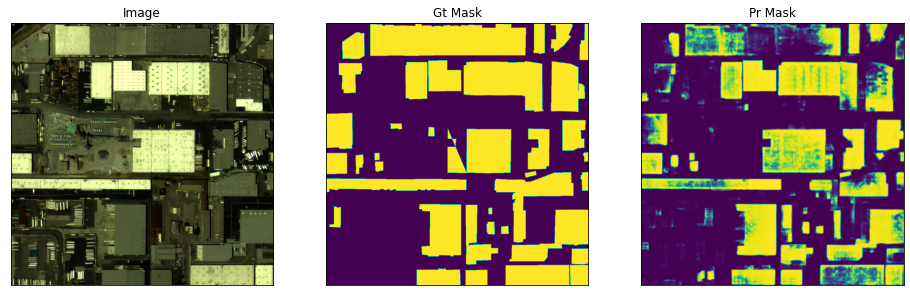

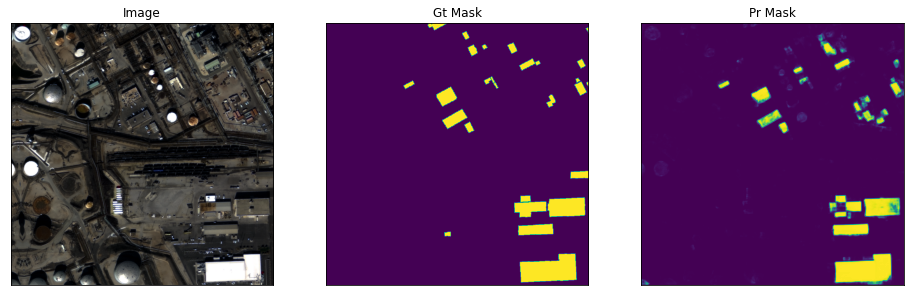

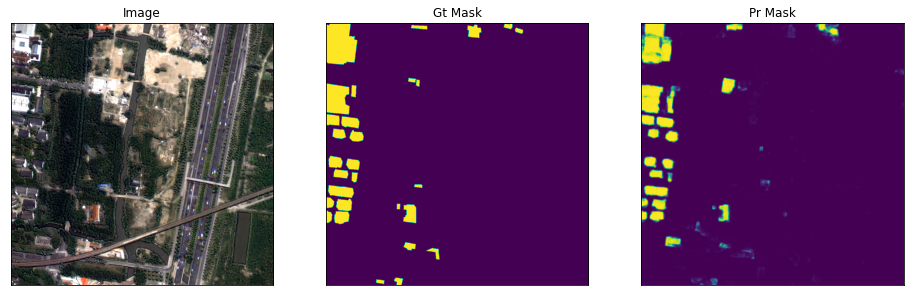

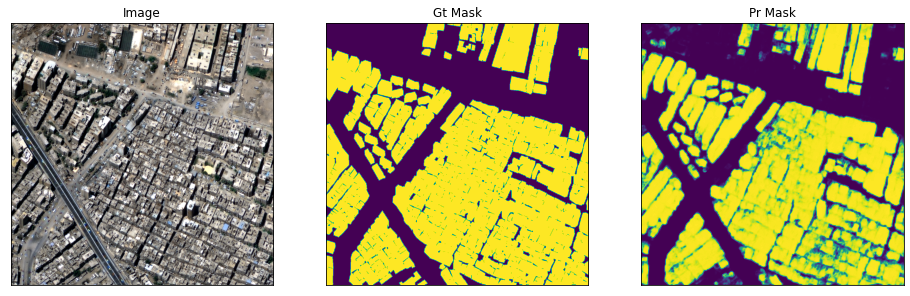

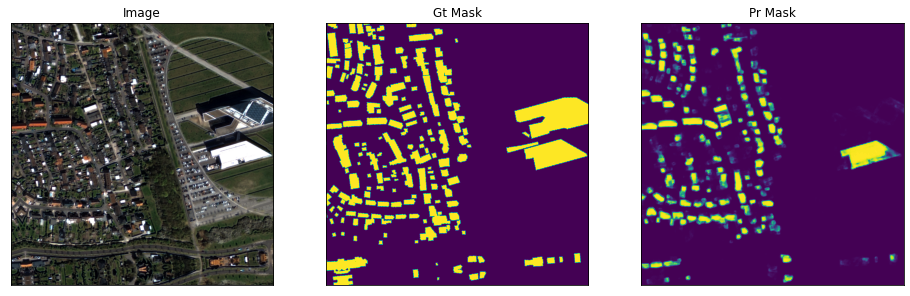

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )